In [1]:
# Title: Cows and chickens
# Author: Valdo Joao - valdojoao90@gmail.com
# Date: 24/06/2019

In [2]:
import numpy as np
import pandas as pd
import math as ma

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.optimizers import SGD
from keras.layers import Conv2D
from keras.layers import MaxPool2D, AvgPool2D
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from itertools import islice
import matplotlib.pyplot as plt

import time

Using TensorFlow backend.


In [3]:
# original dataset
# data
#     -> chickens
#     -> cows

# This is how I have reorganized the data
# data
#     -> test - 20% of the dataset: 815 images
#            -> chickens
#            -> cows
#        
#     -> train - 60% of the dataset: 2403 images
#            -> chickens
#            -> cows
#       
#     -> validation - 20% of the dataset: 814 images
#            -> chickens
#            -> cows

In [4]:
#Design choices:
# 'relu' performs better on NN compared with others activation functions
# A classification problem to distinghih between 2 classes: 
# output_activation = 'sigmoid'; loss = 'binary_crossentropy'
# More than 2 classes we could use activation:softwax loss:categorical_crossentropy
# CNN works well with images, other options could be Random Forest, SVM, etc
# On CNN adaptive learning rate optimzers converge faster, 
# so both 'adam' or 'rmsprop' optimzers are good options

In [5]:
#Dataset parameters
train_folder = '../data_cainthus/train'
test_folder = '../data_cainthus/test'
validation_folder = '../data_cainthus/validation'

#Network parameters 
input_size = 64       
output_size = 1
activation = 'relu'
output_activation = 'sigmoid'

#Trainning parameters
loss = 'binary_crossentropy'
optimizer = 'adam'
metrics = ['accuracy']

batchSize = 32
train_steps = ma.ceil(2403/batchSize)
valid_steps = ma.ceil(814/batchSize)
test_steps = ma.ceil(814/batchSize)
epochs = 150
verbose = 0

In [6]:
# data generator 
datagen = ImageDataGenerator(rescale = 1./255)

# perform some data augmentation on the training images
train_datagen = ImageDataGenerator(rescale = 1./255,
                               width_shift_range=0.1,
                               height_shift_range=0.1,
                               rotation_range = 10,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True)

def get_generator_from_dir(dataGenerator, folder):
    return dataGenerator.flow_from_directory(
    folder,
    target_size = (input_size, input_size),
    batch_size = batchSize,
    shuffle = True,
    class_mode = 'binary')

In [7]:
# generator for reading train data from folder
train_generator = get_generator_from_dir(train_datagen, train_folder)

Found 2403 images belonging to 2 classes.


In [8]:
# generator for reading validation data from folder
validation_generator = get_generator_from_dir(datagen, validation_folder)

Found 814 images belonging to 2 classes.


In [9]:
# generator for reading test data from folder
test_generator = get_generator_from_dir(datagen, test_folder)

Found 815 images belonging to 2 classes.


In [10]:
# neural network model
model = Sequential()

model.add(Conv2D(32, (3,3), input_shape = (input_size, input_size, 3),
                 activation = activation))

model.add(MaxPool2D(pool_size = (2,2)))

model.add(Conv2D(64, (3,3), activation = activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), activation = activation))
model.add(MaxPool2D(pool_size = (2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

# we dont need a hidden layer on the NN as our data can be linearly separable
model.add(Dense(128,activation = activation))
model.add(Dense(output_size , activation = output_activation))

In [11]:
model.compile(loss = loss,
              optimizer = optimizer,
              metrics = metrics)

In [12]:
# get the summary of the Network
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [13]:
#Using GPU could help to decrease a lot the overall computation time

In [15]:
start = time.time()

train_model = model.fit_generator(train_generator,
                    steps_per_epoch = train_steps,
                    epochs = epochs,
                    validation_data = validation_generator,
                    verbose = verbose,
                    validation_steps = valid_steps)

end = time.time()


Training_time = ma.ceil((end - start)/60)
print("Aprox training time in mins: " + str(Training_time))

Aprox training time in mins: 307


In [16]:
model.save('my_model' + '.h5')

In [17]:
# load_model('my_model' + '.h5')

In [18]:
# list all data in history
print(train_model.history.keys())

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


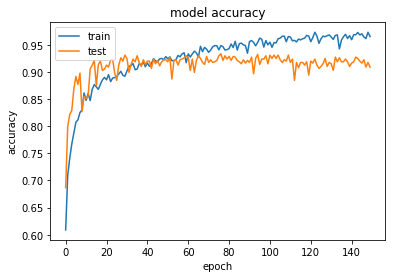

In [19]:
# summarize history for accuracy
plt.plot(train_model.history['acc'])
plt.plot(train_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

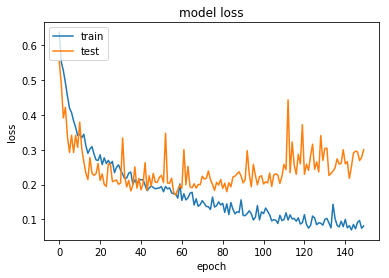

In [20]:
# summarize history for loss
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [21]:
# prepare the data for the prediction
X_test = []
y_test = []

for ts in islice(test_generator, len(test_generator)):
    X_test.append(ts[0])
    y_test.append(ts[1])
    
X_test = np.concatenate(X_test)
y_test = np.concatenate(y_test)

In [22]:
#predict the model
y_pred = model.predict_classes(X_test).ravel()

In [23]:
#get the wrongly predicted values
results = np.argwhere(y_test != y_pred).ravel()
print("index of Wrong predictions: " + str(results))

index of Wrong predictions: [ 26  50  52  55  75 104 107 126 136 149 155 172 179 181 193 195 208 222
 248 263 277 288 304 312 324 342 355 365 374 393 405 410 411 412 418 424
 430 439 453 456 470 473 486 493 512 532 541 549 576 580 581 596 611 629
 638 659 660 675 701 709 710 719 722 728 732 733 739 743 776 784 792 797]


In [24]:
#get the test accuraccy 
test_acc = 1 - (len(results) / len(y_pred))
print("Accuraccy on the test set is: " + str(round(test_acc, 4)))

Accuraccy on the test set is: 0.9117


In [32]:
#Train set acc aprox 97%, validation set acc aprox 92%, test set acc aprox 91%
#The overall results are quite acceptable

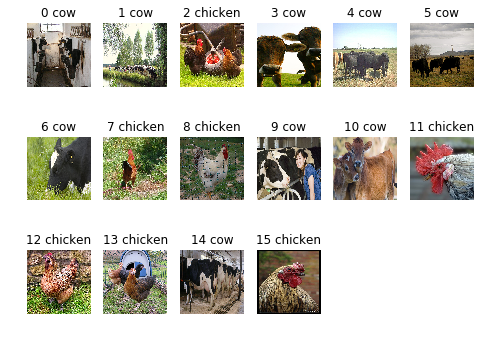

In [25]:
#Vizualization check of the predicted result for a given image of test data set
#classes: 0 chicken; 1 cow 

def animal(i):
    switcher={
                0:' chicken',
                1:' cow'
             }
    return switcher.get(i,"Invalid input")

plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 6, i+1)
    plt.title(str(i) + animal(y_pred[i]))
    plt.axis('off')
    plt.imshow(X_test[i])